In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing RR Lyrae stars for the Blazhko effect

In this notebook we are analyzing the data calculated in nb 03 in order to look into possible Blazhko stars.

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from descriptive_stats import *
from plots import *

from selection import *
from lc_analysis import *

Loading the data!


In [5]:
#| code-fold: false
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

## Loading the data

Here we are loading the data calculated in notebook `03 Analyzing RR Lyrae`. We load the light curve analysis DataFrame, the periodograms and the fits of every light curve.

In [6]:
#| code-fold: false
lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINAL.csv')
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.645075,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.162370,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.137436,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.556614,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.341415,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25


In [7]:
#| code-fold: false
periodograms = pickle.load(open("../outputs/periodograms_final.pkl", "rb"))

In [8]:
#| code-fold: false
FITS = np.load('../outputs/fits_whole.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/fits_whole.npy'

# Preliminary analysis of data

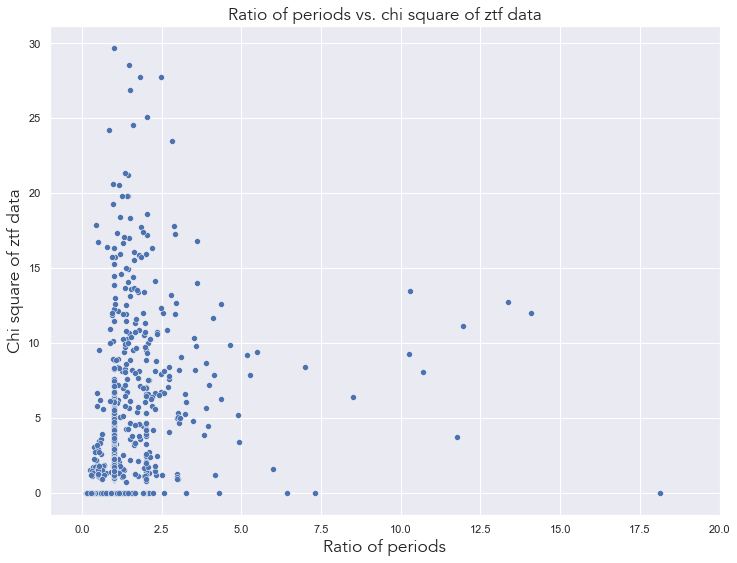

In [9]:
#| label: fig_pratio_vs_chiztf
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of ZTF light curves
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Pratio', y='ZPztf_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of ztf data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

From the graph above we can see that most ratios of periods focus around the 1 mark, with chi quare values increasing along that line. There is another line present which indicates 0 chi square and increasing ratio of periods. The rest of the data is scattered on the graph.

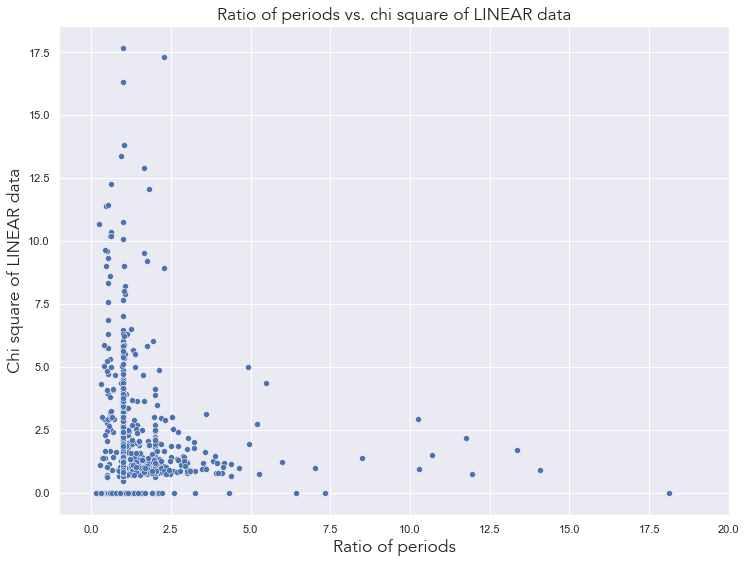

In [10]:
#| label: fig_pratio_vs_LINEARchi
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of LINEAR light curves
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Pratio', y='LPlin_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of LINEAR data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of LINEAR data', fontproperties=font)
plt.show()

From the graph above, we can see the same pattern as with the ZTF data, showing that they are actually quite similar. However, more ratios of periods are scattered near the lower end of the graph (smaller chi values).

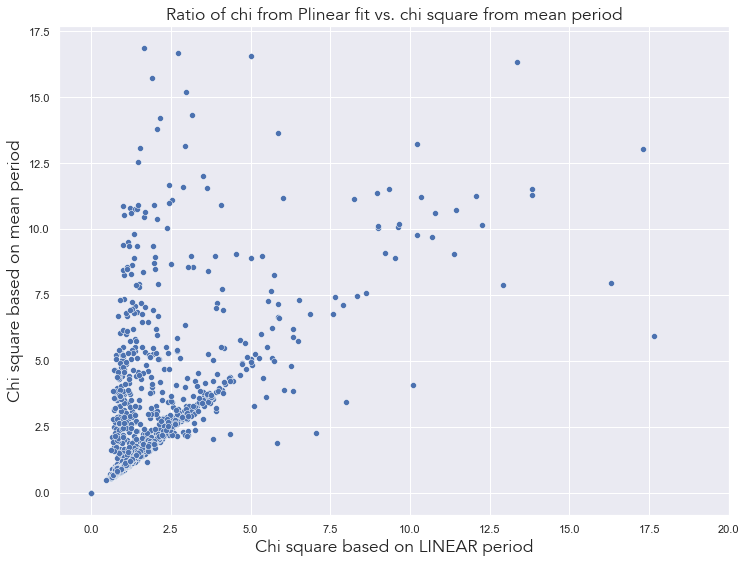

In [11]:
#| label: fig_chiL_vs_chiLmean
#| fig-cap: The chi value based on the fit from the LINEAR period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='LPlin_chi2dofR', y='LPmean_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of chi from Plinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on LINEAR period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

As expected, most values fall on a diagonal line indicating that they should be the same, however a sizeable fraction isn't the same as the mean value, indicating that the `ZTF` period is pushing the mean towards a different direction than the original `LINEAR` period.

- cut na 20-30 tocaka na broj tocaka podataka -> nacrtati histogram za procjeniti koliko treba maknuti tocaka
- odrediti kvalitetne podatke, odbaciti ostalo
- *koliko smo izgubili losih podataka*
- izrezati zvijezde iz dijagrama ispod i analizirati neobicne zvijezde
- napraviti nacin kako uzeti samo dobre zvijezde, nekako automatski proci vizualno kroz krivulje
- analizirati manji probrani sample za blahko effect
- nacrtati dijagram koji usporeduje razlike izmedu chi mean i chi best period za linear i ztf i obojati tocke bazirano na broju tocaka

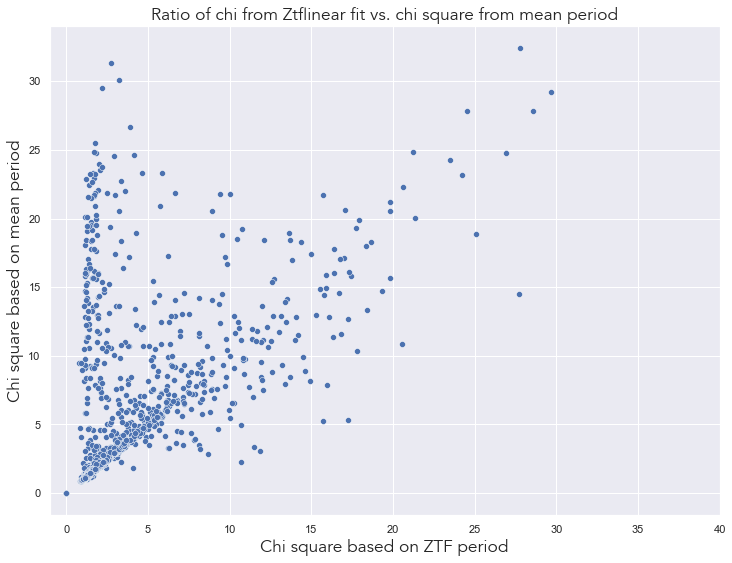

In [12]:
#| label: fig_chiZ_vs_chiZmean
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='ZPztf_chi2dofR', y='ZPmean_chi2dofR')
plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

From the graph above we can also see a diagonal line indicating equality, however the data is slightly more scattered than in the `LINEAR` graph. 

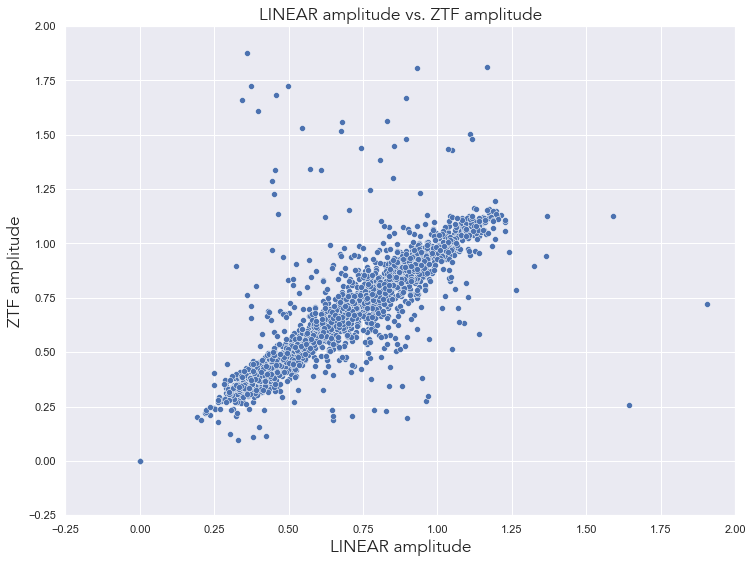

In [13]:
#| label: fig_Lampl_vsZampl
#| fig-cap: The LINEAR amplitude versus the ZTF amplitude
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Lampl', y='Zampl')
plt.xlim(-0.25, 2)
plt.ylim(-0.25, 2)
plt.title('LINEAR amplitude vs. ZTF amplitude', fontproperties=font)
plt.xlabel('LINEAR amplitude', fontproperties=font)
plt.ylabel('ZTF amplitude', fontproperties=font)
plt.show()

As we can see from the graph above, the "equality" line above is quite thick, however there are few scattered light curves. This indicates that there are commonly small changes in the amplitudes.

# Analyzing subsets of total light curve data

In this section we will create subsets of the total database based on special parameters, slowly loosening the criteria for a Blazhko star until we reach the final criterium. In between datasets we will analyze their fits and periodograms.

The parameters:

1. <span style="color:CadetBlue">Ratio of Periods</span>: must be below 0.99 and above 1.01 (when rounded to 2 decimals).

2. <span style="color:CadetBlue">Chi square</span>: has to be above 3 for a significant change for the Blazhko effect.

3. <span style="color:CadetBlue">Indicator from periodogram</span>: `Zindicator` and `Lindicator` should be 1 (however in other situations one or the either can be 1).

4. <span style="color:CadetBlue">Amplitude</span>: if the amplitude change is greater than 0.01.

In [14]:
BLAZHKO_STARS = pd.DataFrame(())

In [15]:
lightcurve_analysis['Pratio'] = round(lightcurve_analysis['Pratio'], 4)
lightcurve_analysis['Ampl_diff'] = round(abs(lightcurve_analysis['Lampl'] - lightcurve_analysis['Zampl']), 3)
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
0,29848,0.557021,0.557037,0.557029,1.0,301.0,0.178198,3.028026,1.451336,0.185326,...,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25,0.358
1,50402,0.643301,0.643296,0.643298,1.0,284.0,0.107683,0.595738,0.733869,0.106092,...,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25,0.001
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.017
3,91437,0.674732,0.674738,0.674735,1.0,177.0,0.040798,2.775415,1.352923,0.040888,...,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25,0.004
4,95250,0.313870,0.313876,0.313873,1.0,222.0,0.162040,0.816590,0.859616,0.165801,...,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.022


In [16]:
chi = 3.0
pratio_less = 0.99
pratio_more = 1.01
ampl = 0.01

### Only Chi square

In [17]:
chi_criteria = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) #& 
                                             #((lightcurve_analysis['Pratio'] > pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] < pratio_more)) & 
                                             #(lightcurve_analysis['Lindicator'] ==1) & 
                                             #(lightcurve_analysis['Zindicator'] ==1) & 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {chi_criteria.shape[0]} rows and {chi_criteria.shape[1]} columns.')
chi_criteria.head()

This dataset has 66 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
145,1790596,0.534497,0.534504,0.534501,1.0000,509.0,0.110318,19.384713,3.068320,0.108207,...,0.061888,15.573548,3.273950,15.050388,0.718432,1,0.25,0.0,0.25,0.072
170,2050107,0.686454,0.686468,0.686461,1.0000,190.0,0.089110,16.505828,3.903771,0.090967,...,0.085768,22.743994,3.355955,14.302818,0.645090,0,0.25,0.0,0.25,0.138
186,2224955,0.999967,0.998525,0.999246,0.9986,139.0,0.000007,70.546675,6.054673,0.160561,...,0.005114,253.611609,3.326470,-60.825583,76.493428,0,0.25,0.0,0.25,25653.388
192,2243683,0.579775,0.579800,0.579787,1.0000,531.0,0.145114,22.047335,3.164640,0.148300,...,0.092839,40.237676,4.084559,14.963473,0.559560,1,0.25,0.0,0.25,0.038
205,2333087,0.551462,0.551424,0.551443,0.9999,560.0,0.136958,29.844745,3.543160,0.126088,...,0.135812,56.853700,5.601486,15.102440,0.580700,1,0.25,0.0,0.25,0.138


### Only Pratio parameter

In [18]:
pratio_criteria = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) #& 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             #(lightcurve_analysis['Lindicator'] ==1) & 
                                             #(lightcurve_analysis['Zindicator'] ==1) & 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_criteria.shape[0]} rows and {pratio_criteria.shape[1]} columns.')
pratio_criteria.head()

This dataset has 558 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
5,104455,0.997210,0.779404,0.888307,0.7816,119.0,0.000019,3.340609,1.637698,0.479566,...,0.476834,198.977212,15.997038,16.426643,0.860027,0,0.25,0.0,0.25,11782.102
6,108513,0.473809,0.736965,0.605387,1.5554,282.0,0.125636,3.973136,1.377105,0.524794,...,0.156509,258.336340,18.970065,15.968586,0.995635,0,0.25,0.0,0.25,0.131
17,258499,0.401505,0.803006,0.602256,2.0000,275.0,0.123031,2.711071,1.493619,0.409720,...,1.675283,130.180418,15.710401,15.247629,0.372447,0,0.25,0.0,0.25,0.031
20,309626,0.595840,0.798118,0.696979,1.3395,215.0,0.097048,20.984336,2.895945,0.429714,...,0.317934,357.068832,18.446596,14.630699,0.802739,0,0.25,0.0,0.25,0.119
31,608497,0.485636,0.781323,0.633479,1.6089,556.0,0.080462,20.343992,2.499514,1.081689,...,0.834255,626.442325,27.802733,15.276444,0.504662,0,0.25,0.0,0.25,0.357


### Only Lindicator parameter

In [19]:
indicator_L = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) #& 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             (lightcurve_analysis['Lindicator'] ==1) #& 
                                             #(lightcurve_analysis['Zindicator'] ==1) & 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {indicator_L.shape[0]} rows and {indicator_L.shape[1]} columns.')
indicator_L.head()

This dataset has 558 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.017
4,95250,0.313870,0.313876,0.313873,1.0,222.0,0.162040,0.816590,0.859616,0.165801,...,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.022
7,136668,0.532922,0.532929,0.532926,1.0,310.0,0.122892,1.639568,1.114588,0.121226,...,0.050996,19.659028,2.478210,16.107864,0.775380,1,0.25,0.0,0.25,0.046
9,142794,0.470787,0.470804,0.470796,1.0,270.0,0.095738,1.814911,0.991759,0.100813,...,0.060053,40.406637,3.570589,15.745773,0.815178,1,0.25,0.0,0.25,0.093
12,163933,0.339629,0.339626,0.339628,1.0,306.0,0.064185,0.972501,0.882843,0.066518,...,0.024081,0.991889,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,0.014


### Only Zindicator parameter

In [20]:
indicator_Z = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) #& 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             #(lightcurve_analysis['Lindicator'] ==1) #& 
                                             (lightcurve_analysis['Zindicator'] ==1) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {indicator_Z.shape[0]} rows and {indicator_Z.shape[1]} columns.')
indicator_Z.head()

This dataset has 342 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
19,303860,0.492145,0.492164,0.492155,1.0,280.0,0.090758,3.474911,1.398451,0.100403,...,0.056274,49.825915,3.438669,15.599545,0.768657,0,0.25,1.0,0.25,0.148
21,355767,0.521368,0.521363,0.521366,1.0,180.0,0.103821,0.987307,0.878734,0.109992,...,0.037770,6.269881,1.994488,16.344715,0.842194,0,0.25,1.0,0.25,0.000
23,418785,0.700122,0.700120,0.700121,1.0,263.0,0.120176,1.443688,0.796597,0.117596,...,0.035619,4.879155,1.245072,16.518551,0.544663,0,0.25,1.0,0.25,0.015
25,437483,0.699235,0.699234,0.699234,1.0,316.0,0.117653,0.517548,0.685323,0.117550,...,0.045664,1.699911,1.045334,16.500213,0.347478,0,0.25,1.0,0.25,0.017
41,813450,0.589389,0.589390,0.589389,1.0,221.0,0.130989,1.978570,1.324242,0.131192,...,0.022873,1.606273,0.994425,15.902661,0.652062,0,0.25,1.0,0.25,0.048


### Both indicators

In [21]:
indicators = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) #& 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             ((lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {indicators.shape[0]} rows and {indicators.shape[1]} columns.')
indicators.head()

This dataset has 70 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
93,1273940,0.382316,0.382328,0.382322,1.0,324.0,0.098100,1.027298,0.952587,0.099502,...,0.066282,4.596897,1.728477,15.718905,0.387768,1,0.25,1.0,0.25,0.014
118,1551619,0.338148,0.338146,0.338147,1.0,295.0,0.077517,1.966842,1.250849,0.078587,...,0.057304,1.881148,1.422460,15.044415,0.330181,1,0.25,1.0,0.25,0.022
197,2280940,0.562371,0.562373,0.562372,1.0,310.0,0.120851,1.422115,1.132398,0.120810,...,0.056192,8.316144,2.207918,16.216935,0.749738,1,0.25,1.0,0.25,0.086
236,2584911,0.379734,0.379726,0.379730,1.0,336.0,0.142132,0.687537,0.758328,0.158001,...,0.061521,2.541375,1.498468,16.287754,0.389628,1,0.25,1.0,0.25,0.011
250,2672050,0.556544,0.556544,0.556544,1.0,260.0,0.107816,1.775792,0.984917,0.110365,...,0.072241,22.868738,3.067281,16.015666,0.668624,1,0.25,1.0,0.25,0.167


### Chi square and the pratio

In [22]:
chi_pratio = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             #((lightcurve_analysis['Lindicator'] ==1) & 
                                             #(lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {chi_pratio.shape[0]} rows and {chi_pratio.shape[1]} columns.')
chi_pratio.head()

This dataset has 27 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
341,3219035,0.326746,0.653037,0.489891,1.9986,376.0,0.229216,23.913563,3.905119,0.613155,...,2.117273,68.528888,10.734223,14.860999,0.236771,0,0.25,0.0,0.25,0.077
510,4450046,0.332411,0.548385,0.440398,1.6497,165.0,0.010739,137.662004,12.914783,0.272217,...,0.883267,330.191623,22.733552,14.631678,0.614358,0,0.25,0.0,0.25,23.974
534,4670587,0.357697,0.715389,0.536543,2.0000,555.0,0.215054,31.782641,4.133402,0.886791,...,1.467387,112.567090,11.831232,14.990952,0.366550,0,0.25,0.0,0.25,0.021
772,7819052,0.999970,0.542454,0.771212,0.5425,294.0,0.000009,79.546237,8.341699,0.794828,...,1.546875,194.687983,16.421559,14.888817,0.632955,0,0.25,0.0,0.25,26685.285
786,7907059,0.203151,0.997047,0.600099,4.9079,204.0,0.438135,33.274663,5.005327,0.594256,...,0.047791,58.383408,4.146061,14.557542,26974.868935,0,0.25,0.0,0.25,26974.628


#### Analyzing chi square and pratio

Based on the analysis below, we drop cases which are absurd from this table and then append promising candidates to the `BLAZHKO STARS` table.

LINEAR ID:3219035
-------------------------


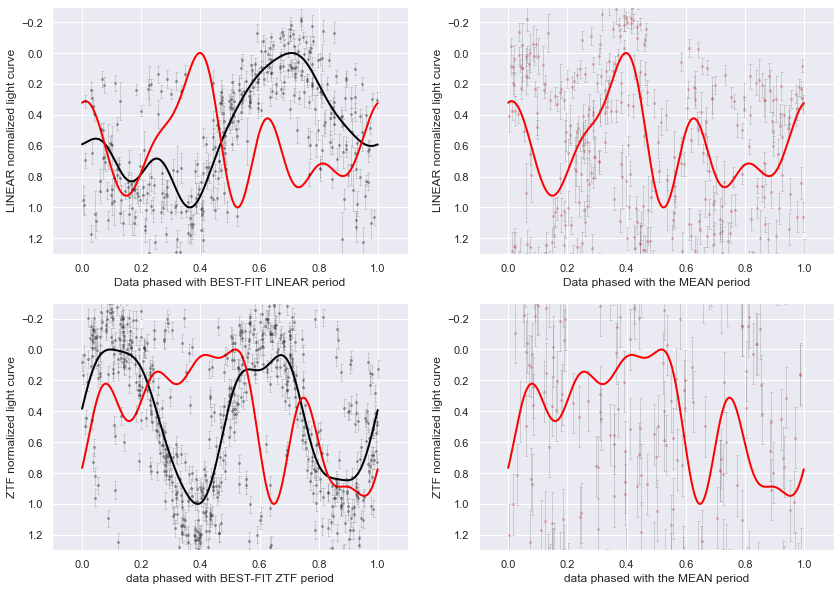

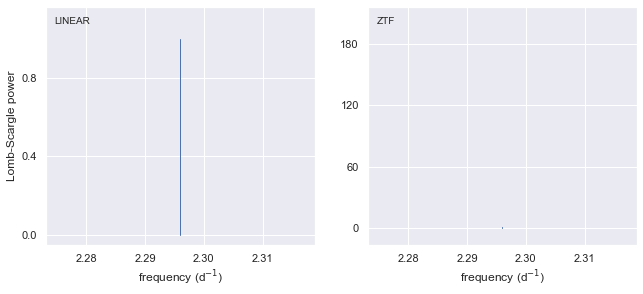

-------------------------


In [91]:
#test = chi_pratio.shape[0]
test = 1
for i in range(test):
    LID = chi_pratio['LINEAR id'].to_numpy()[i]
    print(f'LINEAR ID:{LID}')
    print('-'*25)
    blazhko_analysis(chi_pratio, Lid=LID, order=i, PD=periodograms, fits=FITS)
    print('-'*25)

After analyzing the entire dataset, I have concluded that all of these IDs have horrible data and horrible periodograms, so I am removing them from the dataset.

In [97]:
lightcurve_analysis_dropped = lightcurve_analysis.drop(list(chi_pratio.index))
print("New shape of original dataframe:",lightcurve_analysis_dropped.shape)

New shape of original dataframe: (2683, 28)


### Chi square and the Lindicator

In [23]:
chi_indicators_L = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             (lightcurve_analysis['Lindicator'] ==1) #& 
                                             #(lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {chi_indicators_L.shape[0]} rows and {chi_indicators_L.shape[1]} columns.')
chi_indicators_L.head(7)

This dataset has 7 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
145,1790596,0.534497,0.534504,0.534501,1.0000,509.0,0.110318,19.384713,3.068320,0.108207,...,0.061888,15.573548,3.273950,15.050388,0.718432,1,0.25,0.0,0.25,0.072
192,2243683,0.579775,0.579800,0.579787,1.0000,531.0,0.145114,22.047335,3.164640,0.148300,...,0.092839,40.237676,4.084559,14.963473,0.559560,1,0.25,0.0,0.25,0.038
205,2333087,0.551462,0.551424,0.551443,0.9999,560.0,0.136958,29.844745,3.543160,0.126088,...,0.135812,56.853700,5.601486,15.102440,0.580700,1,0.25,0.0,0.25,0.138
527,4588605,0.424709,0.424650,0.424680,0.9999,593.0,0.171065,12.895032,3.265491,0.246852,...,0.601898,120.682816,12.105620,14.917903,0.205204,1,0.25,0.0,0.25,0.116
1206,11027581,1.014330,35.114993,18.064661,34.6189,215.0,0.062096,25.059080,3.165133,0.377240,...,0.094428,393.875292,17.174011,14.551819,0.878261,1,0.25,0.0,0.25,0.162
2360,20668112,0.310286,0.310278,0.310282,1.0000,202.0,0.128142,18.923149,3.504199,0.135743,...,0.128648,20.055296,5.132169,14.568035,0.442034,1,0.25,0.0,0.25,0.092
2707,24257481,0.291239,0.291218,0.291228,0.9999,303.0,0.317066,43.182249,5.656253,0.402419,...,0.262455,50.313380,7.618723,14.849401,0.415080,1,0.25,0.0,0.25,0.036


LINEAR ID:20668112
-------------------------


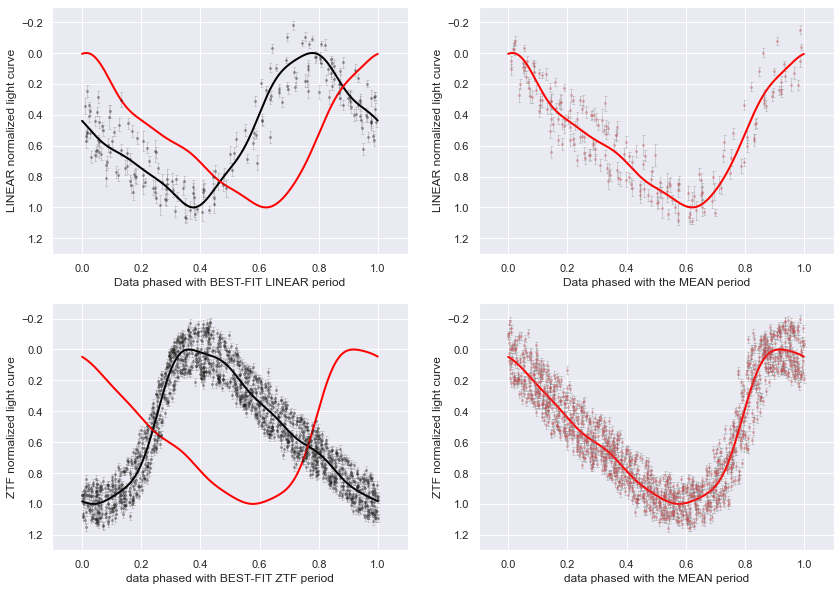

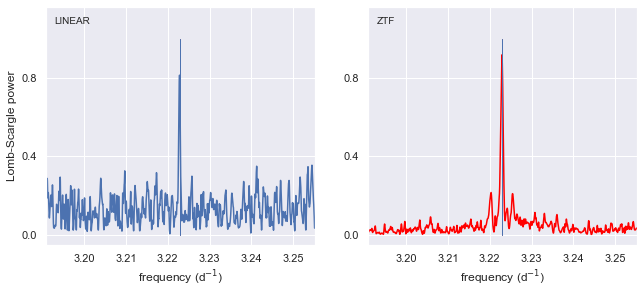

-------------------------


In [100]:
#test = chi_indicators_L.shape[0]
test = 1
for i in range(test):
    LID = chi_indicators_L['LINEAR id'].to_numpy()[i+5]
    print(f'LINEAR ID:{LID}')
    print('-'*25)
    blazhko_analysis(chi_indicators_L, Lid=LID, order=i+5, PD=periodograms, fits=FITS)
    print('-'*25)

Based on the analysis above, only 1 light curve (the above plots) is going to the main dataset, while the rest are being deleted. 

### Chi square and the zindicator

In [24]:
chi_indicators_Z = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             #(lightcurve_analysis['Lindicator'] ==1) #& 
                                             (lightcurve_analysis['Zindicator'] ==1)#) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {chi_indicators_Z.shape[0]} rows and {chi_indicators_Z.shape[1]} columns.')
chi_indicators_Z.head(7)

This dataset has 7 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
256,2698843,0.517522,0.517528,0.517525,1.0000,179.0,0.153972,25.189550,3.125007,0.166404,...,0.114088,60.927684,6.779116,15.051958,0.701229,0,0.25,1.0,0.25,0.134
846,8386990,0.607552,0.607554,0.607553,1.0000,239.0,0.084358,24.010485,3.270724,0.085316,...,0.070113,28.159737,3.494265,14.492204,0.696659,0,0.25,1.0,0.25,0.053
960,9227464,0.352866,0.352858,0.352862,1.0000,352.0,0.291019,34.351614,4.455712,0.299326,...,0.177278,16.241991,3.929267,14.922809,0.298187,0,0.25,1.0,0.25,0.001
1473,13052359,0.331142,0.547876,0.439509,1.6545,159.0,0.294329,20.019477,3.659138,0.675081,...,1.749100,272.687187,18.362307,15.766048,0.776012,0,0.25,1.0,0.25,0.095
1775,15661449,0.364649,0.364725,0.364687,1.0002,156.0,0.181317,10.940299,3.335185,0.275212,...,0.514797,70.200920,9.923064,15.006817,0.318486,0,0.25,1.0,0.25,0.055
1826,16072819,0.506148,0.506141,0.506145,1.0000,176.0,0.111247,17.537860,3.359774,0.125287,...,0.113274,76.287864,6.723749,14.879627,0.682788,0,0.25,1.0,0.25,0.031
2387,21011450,0.997408,0.465170,0.731289,0.4664,184.0,0.001617,137.456001,9.004324,0.348433,...,2.399420,659.913359,30.081139,14.314538,0.873717,0,0.25,1.0,0.25,139.888


### Chi square and indicators

In [25]:
chi_indicators = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) #& 
                                             ((lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {chi_indicators.shape[0]} rows and {chi_indicators.shape[1]} columns.')
chi_indicators.head()

This dataset has 0 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff


### Pratio and Lindicator

In [26]:
pratio_indicator_L = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             (lightcurve_analysis['Lindicator'] ==1) #& 
                                             #(lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_indicator_L.shape[0]} rows and {pratio_indicator_L.shape[1]} columns.')
pratio_indicator_L.head()

This dataset has 59 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
35,734545,0.289482,0.600607,0.445044,2.0748,305.0,0.141460,3.268840,1.686005,1.007203,...,0.166298,48.534045,5.477775,15.115288,0.365456,1,0.25,0.0,0.25,0.072
36,737951,0.357023,0.714022,0.535522,1.9999,273.0,0.234552,5.969929,2.223776,0.886546,...,1.630976,132.342576,14.039679,15.770017,0.334559,1,0.25,0.0,0.25,0.089
45,869112,0.635690,1.500190,1.067940,2.3599,322.0,0.096359,0.979763,0.876514,0.631570,...,0.182282,19.880544,5.060452,15.548891,1.659516,1,0.25,0.0,0.25,1.316
51,899832,0.589464,6.932400,3.760932,11.7605,285.0,0.056962,9.200564,2.170517,0.423627,...,0.164459,61.557798,8.210761,14.512044,1.338153,1,0.25,0.0,0.25,0.730
229,2532118,0.338381,1.321389,0.829885,3.9050,273.0,0.126001,1.236176,0.787268,0.682297,...,0.063335,28.428227,2.838066,16.250300,0.348792,1,0.25,0.0,0.25,0.090


### Pratio and Zindicator

In [27]:
pratio_indicator_Z = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             #(lightcurve_analysis['Lindicator'] ==1) #& 
                                             (lightcurve_analysis['Zindicator'] ==1)#) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_indicator_Z.shape[0]} rows and {pratio_indicator_Z.shape[1]} columns.')
pratio_indicator_Z.head()

This dataset has 49 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
103,1440217,1440217.0,0.340550,0.000000,0.1703,0.000000,574.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.25,0.0
132,1679845,1679845.0,0.683381,0.000000,0.3417,0.000000,441.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.25,0.0
144,1788821,1788821.0,0.571804,0.000000,0.2859,0.000000,521.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.25,0.0
160,1913043,1913043.0,0.631498,0.000000,0.3157,0.000000,548.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.25,0.0
207,2341370,2341370.0,0.579899,2.656165,1.6180,4.580389,562.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.25,0.0


### Pratio and indicators

In [28]:
pratio_indicators = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             #(lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             ((lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_indicators.shape[0]} rows and {pratio_indicators.shape[1]} columns.')
pratio_indicators.head()

This dataset has 3 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
847,8395250,0.506557,0.499347,0.502952,0.9858,230.0,0.043179,1.305252,1.130811,0.545484,...,0.502000,242.569678,14.723863,-108.292846,124.492605,1,0.25,1.0,0.25,123.434
935,9038263,0.333029,0.337840,0.335434,1.0144,237.0,0.348092,10.847589,3.600996,0.870666,...,1.091519,50.346698,9.346259,15.663089,0.321234,1,0.25,1.0,0.25,0.150
1314,11782815,0.329138,0.349130,0.339134,1.0607,171.0,0.424626,65.908900,8.234187,0.782024,...,1.295204,118.922499,15.274592,14.511572,0.399737,1,0.25,1.0,0.25,0.076


### Pratio, chi and Lindicator

In [29]:
pratio_chi_indicator_L = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             (lightcurve_analysis['Lindicator'] ==1) #& 
                                             #(lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_chi_indicator_L.shape[0]} rows and {pratio_chi_indicator_L.shape[1]} columns.')
pratio_chi_indicator_L.head()

This dataset has 1 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
1206,11027581,1.01433,35.114993,18.064661,34.6189,215.0,0.062096,25.05908,3.165133,0.37724,...,0.094428,393.875292,17.174011,14.551819,0.878261,1,0.25,0.0,0.25,0.162


### Pratio, chi and Zindicator

In [30]:
pratio_chi_indicator_Z = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             #(lightcurve_analysis['Lindicator'] ==1) #& 
                                             (lightcurve_analysis['Zindicator'] ==1)#) & 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_chi_indicator_Z.shape[0]} rows and {pratio_chi_indicator_Z.shape[1]} columns.')
pratio_chi_indicator_Z.head()

This dataset has 2 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
1473,13052359,0.331142,0.547876,0.439509,1.6545,159.0,0.294329,20.019477,3.659138,0.675081,...,1.74910,272.687187,18.362307,15.766048,0.776012,0,0.25,1.0,0.25,0.095
2387,21011450,0.997408,0.465170,0.731289,0.4664,184.0,0.001617,137.456001,9.004324,0.348433,...,2.39942,659.913359,30.081139,14.314538,0.873717,0,0.25,1.0,0.25,139.888


### Pratio, chi and both indicators

In [31]:
pratio_chi_indicators = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             ((lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             #(lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {pratio_chi_indicators.shape[0]} rows and {pratio_chi_indicators.shape[1]} columns.')
pratio_chi_indicators.head()

This dataset has 0 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff


### Amplitudes and chi

In [32]:
amplitudes_chi = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                            # ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                            # (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                            # ((lightcurve_analysis['Lindicator'] ==1) & 
                                           #  (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_chi.shape[0]} rows and {amplitudes_chi.shape[1]} columns.')
amplitudes_chi.head()

This dataset has 64 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
145,1790596,0.534497,0.534504,0.534501,1.0000,509.0,0.110318,19.384713,3.068320,0.108207,...,0.061888,15.573548,3.273950,15.050388,0.718432,1,0.25,0.0,0.25,0.072
170,2050107,0.686454,0.686468,0.686461,1.0000,190.0,0.089110,16.505828,3.903771,0.090967,...,0.085768,22.743994,3.355955,14.302818,0.645090,0,0.25,0.0,0.25,0.138
186,2224955,0.999967,0.998525,0.999246,0.9986,139.0,0.000007,70.546675,6.054673,0.160561,...,0.005114,253.611609,3.326470,-60.825583,76.493428,0,0.25,0.0,0.25,25653.388
192,2243683,0.579775,0.579800,0.579787,1.0000,531.0,0.145114,22.047335,3.164640,0.148300,...,0.092839,40.237676,4.084559,14.963473,0.559560,1,0.25,0.0,0.25,0.038
205,2333087,0.551462,0.551424,0.551443,0.9999,560.0,0.136958,29.844745,3.543160,0.126088,...,0.135812,56.853700,5.601486,15.102440,0.580700,1,0.25,0.0,0.25,0.138


### Amplitudes and pratio

In [33]:
amplitudes_pratio = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                            # (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                            # ((lightcurve_analysis['Lindicator'] ==1) & 
                                           #  (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_pratio.shape[0]} rows and {amplitudes_pratio.shape[1]} columns.')
amplitudes_pratio.head()

This dataset has 353 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
5,104455,0.997210,0.779404,0.888307,0.7816,119.0,0.000019,3.340609,1.637698,0.479566,...,0.476834,198.977212,15.997038,16.426643,0.860027,0,0.25,0.0,0.25,11782.102
6,108513,0.473809,0.736965,0.605387,1.5554,282.0,0.125636,3.973136,1.377105,0.524794,...,0.156509,258.336340,18.970065,15.968586,0.995635,0,0.25,0.0,0.25,0.131
17,258499,0.401505,0.803006,0.602256,2.0000,275.0,0.123031,2.711071,1.493619,0.409720,...,1.675283,130.180418,15.710401,15.247629,0.372447,0,0.25,0.0,0.25,0.031
20,309626,0.595840,0.798118,0.696979,1.3395,215.0,0.097048,20.984336,2.895945,0.429714,...,0.317934,357.068832,18.446596,14.630699,0.802739,0,0.25,0.0,0.25,0.119
31,608497,0.485636,0.781323,0.633479,1.6089,556.0,0.080462,20.343992,2.499514,1.081689,...,0.834255,626.442325,27.802733,15.276444,0.504662,0,0.25,0.0,0.25,0.357


### Amplitude and Lindicator

In [34]:
amplitudes_indicator_L = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                            # (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             (lightcurve_analysis['Lindicator'] ==1) & 
                                           #  (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_indicator_L.shape[0]} rows and {amplitudes_indicator_L.shape[1]} columns.')
amplitudes_indicator_L.head()

This dataset has 448 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.017
4,95250,0.313870,0.313876,0.313873,1.0,222.0,0.162040,0.816590,0.859616,0.165801,...,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,0.022
7,136668,0.532922,0.532929,0.532926,1.0,310.0,0.122892,1.639568,1.114588,0.121226,...,0.050996,19.659028,2.478210,16.107864,0.775380,1,0.25,0.0,0.25,0.046
9,142794,0.470787,0.470804,0.470796,1.0,270.0,0.095738,1.814911,0.991759,0.100813,...,0.060053,40.406637,3.570589,15.745773,0.815178,1,0.25,0.0,0.25,0.093
12,163933,0.339629,0.339626,0.339628,1.0,306.0,0.064185,0.972501,0.882843,0.066518,...,0.024081,0.991889,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,0.014


### Amplitude and zindicator

In [35]:
amplitudes_indicator_Z = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                            # (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             #(lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1) & 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_indicator_Z.shape[0]} rows and {amplitudes_indicator_Z.shape[1]} columns.')
amplitudes_indicator_Z.head()

This dataset has 260 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
19,303860,0.492145,0.492164,0.492155,1.0,280.0,0.090758,3.474911,1.398451,0.100403,...,0.056274,49.825915,3.438669,15.599545,0.768657,0,0.25,1.0,0.25,0.148
23,418785,0.700122,0.700120,0.700121,1.0,263.0,0.120176,1.443688,0.796597,0.117596,...,0.035619,4.879155,1.245072,16.518551,0.544663,0,0.25,1.0,0.25,0.015
25,437483,0.699235,0.699234,0.699234,1.0,316.0,0.117653,0.517548,0.685323,0.117550,...,0.045664,1.699911,1.045334,16.500213,0.347478,0,0.25,1.0,0.25,0.017
41,813450,0.589389,0.589390,0.589389,1.0,221.0,0.130989,1.978570,1.324242,0.131192,...,0.022873,1.606273,0.994425,15.902661,0.652062,0,0.25,1.0,0.25,0.048
93,1273940,0.382316,0.382328,0.382322,1.0,324.0,0.098100,1.027298,0.952587,0.099502,...,0.066282,4.596897,1.728477,15.718905,0.387768,1,0.25,1.0,0.25,0.014


### Amplitude and indicators

In [36]:
amplitudes_indicators = lightcurve_analysis.loc[#(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                            # (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             #((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             #(lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             ((lightcurve_analysis['Lindicator'] ==1) & 
                                             (lightcurve_analysis['Zindicator'] ==1)) & 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_indicators.shape[0]} rows and {amplitudes_indicators.shape[1]} columns.')
amplitudes_indicators.head()

This dataset has 56 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
93,1273940,0.382316,0.382328,0.382322,1.0,324.0,0.098100,1.027298,0.952587,0.099502,...,0.066282,4.596897,1.728477,15.718905,0.387768,1,0.25,1.0,0.25,0.014
118,1551619,0.338148,0.338146,0.338147,1.0,295.0,0.077517,1.966842,1.250849,0.078587,...,0.057304,1.881148,1.422460,15.044415,0.330181,1,0.25,1.0,0.25,0.022
197,2280940,0.562371,0.562373,0.562372,1.0,310.0,0.120851,1.422115,1.132398,0.120810,...,0.056192,8.316144,2.207918,16.216935,0.749738,1,0.25,1.0,0.25,0.086
236,2584911,0.379734,0.379726,0.379730,1.0,336.0,0.142132,0.687537,0.758328,0.158001,...,0.061521,2.541375,1.498468,16.287754,0.389628,1,0.25,1.0,0.25,0.011
250,2672050,0.556544,0.556544,0.556544,1.0,260.0,0.107816,1.775792,0.984917,0.110365,...,0.072241,22.868738,3.067281,16.015666,0.668624,1,0.25,1.0,0.25,0.167


### Amplitude, chi and pratio

In [37]:
amplitudes_chi_pratio = lightcurve_analysis.loc[(lightcurve_analysis['LPlin_chi2dofR'] > chi) & 
                                             (lightcurve_analysis['ZPztf_chi2dofR'] >chi) & 
                                             ((lightcurve_analysis['Pratio'] < pratio_less) | 
                                             (lightcurve_analysis['Pratio'] > pratio_more)) & 
                                             #(lightcurve_analysis['Lindicator'] ==1) & 
                                           #  (lightcurve_analysis['Zindicator'] ==1)) #& 
                                             (lightcurve_analysis['Ampl_diff'] > ampl)
                                             ]

print(f'This dataset has {amplitudes_chi_pratio.shape[0]} rows and {amplitudes_chi_pratio.shape[1]} columns.')
amplitudes_chi_pratio.head()

This dataset has 27 rows and 28 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Ampl_diff
341,3219035,0.326746,0.653037,0.489891,1.9986,376.0,0.229216,23.913563,3.905119,0.613155,...,2.117273,68.528888,10.734223,14.860999,0.236771,0,0.25,0.0,0.25,0.077
510,4450046,0.332411,0.548385,0.440398,1.6497,165.0,0.010739,137.662004,12.914783,0.272217,...,0.883267,330.191623,22.733552,14.631678,0.614358,0,0.25,0.0,0.25,23.974
534,4670587,0.357697,0.715389,0.536543,2.0000,555.0,0.215054,31.782641,4.133402,0.886791,...,1.467387,112.567090,11.831232,14.990952,0.366550,0,0.25,0.0,0.25,0.021
772,7819052,0.999970,0.542454,0.771212,0.5425,294.0,0.000009,79.546237,8.341699,0.794828,...,1.546875,194.687983,16.421559,14.888817,0.632955,0,0.25,0.0,0.25,26685.285
786,7907059,0.203151,0.997047,0.600099,4.9079,204.0,0.438135,33.274663,5.005327,0.594256,...,0.047791,58.383408,4.146061,14.557542,26974.868935,0,0.25,0.0,0.25,26974.628


### Amplitudes, chi and lindicator